# Reinforcement learning for chatbot

Credit : 
1.   Jiwei Li (Author credit) 
2.   Lisen Dai (code credit)



## Intro : 
Recent neural models of dialogue generation
offer great promise for generating responses
for conversational agents, but tend to be shortsighted, predicting utterances one at a time
while ignoring their influence on future outcomes. Modeling the future direction of a dialogue is crucial to generating coherent, interesting dialogues, a need which led traditional NLP models of dialogue to draw on reinforcement learning. <etl. Jiwei Li>

you can refer to the publication for your reference.

publication link : https://arxiv.org/pdf/1606.01541.pdf

In this work they simulate conversations between the two virtual agents and have them take turns talking with each
other. <etl. Jiwei Li>

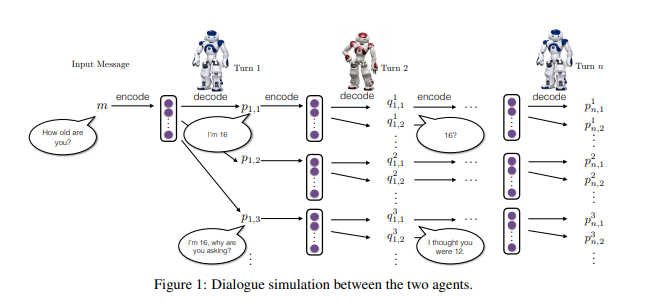

The simulation proceeds as follows: 


*   At the initial step, a message from the training set is fed to the first agent
*   The agent encodes the input message
to a vector representation and starts decoding to generate a response output.
*   Combining the immediate output from the first agent with the dialogue history, the second agent updates the state by encoding the dialogue history into a representation and uses the decoder RNN to generate responses, which are subsequently fed back to the first agent, and the process is repeated.



# Let's start to build the RL bot
Things to do 
* Need to save the data file into the gdrive


# Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Installing the Dependencies

In [ ]:
!pip install torch==1.6

In [ ]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import numpy as np
from scipy.spatial import distance


# Data Loading

We use very standard dataset named "DailyDialog". DailyDialog is a high-quality multi-turn dialog dataset, human-written and less noisy.

In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

# handle dull_responses now
DULL_RESPONSES = ["I do not know what you are talking about.", "I do not know.", "You do not know.",
                  "You know what I mean.", "I know what you mean.", "You know what I am saying.", "You do not know anything."]


class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD",
                           SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(
                keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD",
                           SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count default tokens

        for word in keep_words:
            self.add_word(word)


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object


def read_vocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs


# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filter_pair(p, max_length=15):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length

# Filter pairs using filterPair condition


def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]


# Using the functions defined above, return a populated voc object and pairs list
def load_prepare_data(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = read_vocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filter_pairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for d in DULL_RESPONSES:
        voc.add_sentence(d)
    for pair in pairs:
        voc.add_sentence(pair[0])
        voc.add_sentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


def trim_rare_words(voc, pairs, min_count=3):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(min_count)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(
        len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


def indexes_from_sentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zero_padding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))


def binary_matrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths


def input_var(l, voc):
    indexes_batch = [indexes_from_sentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    pad_list = zero_padding(indexes_batch)
    pad_var = torch.LongTensor(pad_list)
    return pad_var, lengths

# Returns padded target sequence tensor, padding mask, and max target length


def output_var(l, voc):
    indexes_batch = [indexes_from_sentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    pad_list = zero_padding(indexes_batch)
    mask = binary_matrix(pad_list)
    mask = torch.BoolTensor(mask)
    pad_var = torch.LongTensor(pad_list)
    return pad_var, mask, max_target_len

# Returns all items for a given batch of pairs


def batch_2_train_data(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = input_var(input_batch, voc)
    output, mask, max_target_len = output_var(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


if __name__ == '__main__':
    corpus_name = "train"
    corpus = os.path.join("/gdrive/MyDrive/data", corpus_name)
    datafile = os.path.join(corpus, "formatted_dialogues_train.txt")

    # Load/Assemble voc and pairs
    save_dir = os.path.join("data", "save")
    voc, pairs = load_prepare_data(corpus, corpus_name, datafile, save_dir)
    # Print some pairs to validate
    print("\npairs:")
    for pair in pairs[:10]:
        print(pair)
    pairs = trim_rare_words(voc, pairs, min_count=3)

    # Example for validation
    small_batch_size = 5
    batches = batch_2_train_data(voc, [random.choice(pairs) for _ in range(small_batch_size)])
    input_variable, lengths, target_variable, mask, max_target_len = batches

    print("input_variable:", input_variable)
    print("lengths:", lengths)
    print("target_variable:", target_variable)
    print("mask:", mask)
    print("max_target_len:", max_target_len)



Start preparing training data ...
Reading lines...
Read 76053 sentence pairs
Trimmed to 37041 sentence pairs
Counting words...
Counted words: 9514

pairs:
['say jim how about going for a few beers after dinner ?', 'you know that is tempting but is really not good for our fitness .']
['you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .']
['good .let s go now .', 'all right .']
['really ? i think that s impossible !', 'you mean push ups ?']
['you mean push ups ?', 'yeah !']
['can you study with the radio on ?', 'no i listen to background music .']
['no i listen to background music .', 'what is the difference ?']
['what is the difference ?', 'the radio has too many comerials .']
['the radio has too many comerials .', 'that s true but then you have to buy a record player .']
['don t worry .he is an acrobat', 'i see .']
keep_words 5659 / 9511 = 0.5950
Trimmed from 37041 pairs to 32259, 0.8709 of total
input_variable: tensor([[

# Data preprocessing 






In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

corpus_name = "dailydialog"
corpus = os.path.join("data", corpus_name)


def print_lines(file, n=10):
    with open(file, 'r', encoding="utf-8") as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

# Splits each line of the file into a dictionary of fields


def load_lines(file_name):
    conversations = []
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split("__eou__")
            conversations.append(values)
    return conversations


# Extracts pairs of sentences from conversations
def extract_sentence_pairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        # We ignore the last line (no answer for it)
        for i in range(len(conversation) - 1):
            input_line = conversation[i].strip()
            target_line = conversation[i+1].strip()
            # Filter wrong samples (if one of the lists is empty)
            if input_line and target_line:
                qa_pairs.append([input_line, target_line])
    return qa_pairs


def create_formatted_dataset(source, target, type=None):
    # Define path to new file
    datafile = target

    delimiter = '\t'
    # Unescape the delimiter
    delimiter = str(codecs.decode(delimiter, "unicode_escape"))

    print("\nLoading conversations...")
    conversations = load_lines(source)

    # Write new csv file
    print("\nWriting newly formatted file...")
    with open(datafile, 'w', encoding='utf-8') as outputfile:
        writer = csv.writer(outputfile, delimiter=delimiter,
                            lineterminator='\n')
        for pair in extract_sentence_pairs(conversations):
            writer.writerow(pair)

    # Print a sample of lines
    print("\nSample lines from file:")
    print_lines(datafile)




if __name__ == "__main__":
    create_formatted_dataset(
        source="/gdrive/MyDrive/data/train/dialogues_train.txt",
        target="/gdrive/MyDrive/data/train/formatted_dialogues_train.txt",
    )

    create_formatted_dataset(
        source="/gdrive/MyDrive/data/validation/dialogues_validation.txt",
        target="/gdrive/MyDrive/data/validation/formatted_dialogues_validation.txt",
    )

    create_formatted_dataset(
        source="/gdrive/MyDrive/data/test/dialogues_test.txt",
        target="/gdrive/MyDrive/data/test/formatted_dialogues_test.txt",
    )



Loading conversations...

Writing newly formatted file...

Sample lines from file:
Say , Jim , how about going for a few beers after dinner ?	You know that is tempting but is really not good for our fitness .

You know that is tempting but is really not good for our fitness .	What do you mean ? It will help us to relax .

What do you mean ? It will help us to relax .	Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ?

Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ?	I guess you are right.But what shall we do ? I don't feel like sitting at home .

I guess you are right.But what shall we do ? I don't feel like sitting at home .	I suggest a walk over to the gym where we can play singsong and meet some of our friends .

I suggest a walk over to the gym where we can play singsong and meet some of our friends .	That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we ca

# Defining Loss function

In [ ]:
def mask_nll_loss(inp, target, mask):

    # device choice
    USE_CUDA = torch.cuda.is_available()
    device = torch.device("cuda" if USE_CUDA else "cpu")
    
    n_total = mask.sum()
    cross_entropy = - \
        torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = cross_entropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, n_total.item()

# Helper functions

In [ ]:
def convert_response(response, batch_size):
    size1 = len(response)
    size2 = batch_size
    np_res = np.zeros((size1, size2), dtype=np.int64)
    np_lengths = np.zeros(size2, dtype=np.int64)
    for i in range(size1):
        prov = response[i].cpu().numpy()
        for j in range(prov.size):
            np_lengths[j] = np_lengths[j] + 1
            if prov.size > 1:
                np_res[i][j] = prov[j]
            else:
                np_res[i][j] = prov
    res = torch.from_numpy(np_res)
    lengths = torch.from_numpy(np_lengths)
    return res, lengths


def convert_target(target, batch_size):
    size1 = len(target)
    size2 = batch_size
    np_res = np.zeros((size1, size2), dtype=np.int64)
    mask = np.zeros((size1, size2), dtype=np.bool_)
    np_lengths = np.zeros(size2, dtype=np.int64)
    for i in range(size1):
        prov = target[i].cpu().numpy()
        for j in range(prov.size):
            np_lengths[j] = np_lengths[j] + 1
            if prov.size > 1:
                np_res[i][j] = prov[j]
            else:
                np_res[i][j] = prov

            if np_res[i][j] > 0:
                mask[i][j] = True
            else:
                mask[i][j] = False

    res = torch.from_numpy(np_res)
    lengths = torch.from_numpy(np_lengths)
    mask = torch.from_numpy(mask)
    max_target_len = torch.max(lengths)  # .detach().numpy()
    return res, mask, max_target_len


def transform_tensor_to_same_shape_as(tensor, shape):
    size1, size2 = shape
    np_new_t = np.zeros((size1, size2), dtype=np.int64)
    np_new_mask = np.zeros((size1, size2), dtype=np.bool_)
    tensor_size1, tensor_size2 = tensor.size()
    for i in range(tensor_size1):
        for j in range(tensor_size2):
            np_new_t[i][j] = tensor[i][j]
            np_new_mask[i][j] = True
    return torch.from_numpy(np_new_t), torch.from_numpy(np_new_mask)


In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token


class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + \
            outputs[:, :, self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden


# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(
                self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat(
            (hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)


class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden


class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # device choice
        USE_CUDA = torch.cuda.is_available()
        device = torch.device("cuda" if USE_CUDA else "cpu")

        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:self.decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(
            1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores


# Train your RL model

In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token


def rl(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, batch_size, teacher_forcing_ratio):
    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for rnn packing should always be on the cpu
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    #print_losses = []
    response = []

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            #print_losses.append(mask_loss.item() * nTotal)
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor(
                [[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, n_total = mask_nll_loss(
                decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            #print_losses.append(mask_loss.item() * nTotal)

            #ni or decoder_output
            response.append(topi)

    return loss, max_target_len, response


def ease_of_answering(input_variable, lengths, dull_responses, mask, max_target_len, encoder, decoder, batch_size, teacher_forcing_ratio):
    NS=len(dull_responses)
    r1=0
    for d in dull_responses:
        d, mask, max_target_len = output_var(d, voc)
        newD, newMask = transform_tensor_to_same_shape_as(d, input_variable.size())
        #tar, mask, max_target_len = convertTarget(d)
        forward_loss, forward_len, _ = rl(input_variable, lengths, newD, newMask, max_target_len, encoder, decoder, batch_size, teacher_forcing_ratio)
        # log (1/P(a|s)) = CE  --> log(P(a | s)) = - CE
        if forward_len > 0:
            r1 -= forward_loss / forward_len
    if len(dull_responses) > 0:
        r1 = r1 / NS
    return r1


def information_flow(responses):
    r2=0
    if(len(responses) > 2):
        #2 representations obtained from the encoder for two consecutive turns pi and pi+1
        h_pi = responses[-3]
        h_pi1 = responses[-1]
        # length of the two vector might not match
        min_length = min(len(h_pi), len(h_pi+1))
        h_pi = h_pi[:min_length]
        h_pi1 = h_pi1[:min_length]
        #cosine similarity 
        #cos_sim = 1 - distance.cosine(h_pi, h_pi1)
        cos_sim = 1 - distance.cdist(h_pi.cpu().numpy(), h_pi1.cpu().numpy(), 'cosine')
        #Handle negative cos_sim
        if np.any(cos_sim <= 0):
            r2 = - cos_sim
        else:
            r2 = - np.log(cos_sim)
        r2 = np.mean(r2)
    return r2

def semantic_coherence(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder, forward_decoder, backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio):
    #print("IN R3:")
    #print("Input_variable :", input_variable.shape)
    #print("Lengths :", lengths.shape)
    #print("Target_variable :", target_variable.shape)
    #print("Mask :", mask.shape)
    #print("Max_Target_Len :", max_target_len)
    r3 = 0
    forward_loss, forward_len, _ = rl(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder, forward_decoder, batch_size, teacher_forcing_ratio)
    ep_input, lengths_trans = convert_response(target_variable, batch_size)
    #print("ep_input :", ep_input.shape)
    #print("Lengths transformed :", lengths_trans.shape)
    ep_target, mask_trans, max_target_len_trans = convert_target(target_variable, batch_size)
    #print("ep_target :", ep_target.shape)
    #print("mask transformed :", mask_trans.shape)
    #print("max_target_len_trans :", max_target_len_trans)
    backward_loss, backward_len, _ = rl(ep_input, lengths_trans, ep_target, mask_trans, max_target_len_trans, backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio)
    if forward_len > 0:
        r3 += forward_loss / forward_len
    if backward_len > 0:
        r3+= backward_loss / backward_len
    return r3

l1=0.25
l2=0.25
l3=0.5

dull_responses = ["i do not know what you are talking about.", "i do not know.", "you do not know.", "you know what i mean.", "i know what you mean.", "you know what i am saying.", "you do not know anything."]

MIN_COUNT = 3
MAX_LENGTH = 15

def calculate_rewards(input_var, lengths, target_var, mask, max_target_len, forward_encoder, forward_decoder, backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio):
    #rewards per episode
    ep_rewards = []
    #indice of current episode
    ep_num = 1
    #list of responses
    responses = []
    #input of current episode
    ep_input = input_var
    #target of current episode
    ep_target = target_var
    
    #ep_num bounded -> to redefine (MEDIUM POST)
    while (ep_num <= 10):
        
        print(ep_num)
        #generate current response with the forward model
        _, _, curr_response = rl(ep_input, lengths, ep_target, mask, max_target_len, forward_encoder, forward_decoder, batch_size, teacher_forcing_ratio)
        
        #Break if :
        # 1 -> dull response
        # 2 -> response is less than MIN_LENGTH
        # 3 -> repetition ie curr_response in responses
        if(len(curr_response) < MIN_COUNT):# or (curr_response in dull_responses) or (curr_response in responses)):
            break
            
            
        #We can add the response to responses list
        #curr_response = torch.LongTensor(curr_response).view(-1, 1)
        #transform curr_response size
        #target = torch.zeros(960, 1)
        #target[:15, :] = curr_response
        #curr_response = target
        #print(curr_response.size())
        #curr_response = torch.reshape(curr_response, (15, 64))
        #print(curr_response.size())
        #curr_response = curr_response.to(device)
        #responses.append(curr_response) 
        
        
        #Ease of answering
        r1 = ease_of_answering(ep_input, lengths, dull_responses, mask, max_target_len, forward_encoder, forward_decoder, batch_size, teacher_forcing_ratio)
        
        #Information flow
        r2 = information_flow(responses)
        
        #Semantic coherence
        r3 = semantic_coherence(ep_input, lengths, target_var, mask, max_target_len, forward_encoder, forward_decoder, backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio)
        
        #Final reward as a weighted sum of rewards
        r = l1*r1 + l2*r2 + l3*r3
        
        #Add the current reward to the list
        ep_rewards.append(r.detach().cpu().numpy())
        
        #We can add the response to responses list
        curr_response, lengths = convert_response(curr_response, batch_size)
        curr_response = curr_response.to(device)
        responses.append(curr_response)
        
        #Next input is the current response
        ep_input = curr_response
        #Next target -> dummy
        ep_target = torch.zeros(MAX_LENGTH,batch_size,dtype=torch.int64)
        #ep_target = torch.LongTensor(torch.LongTensor([0] * MAX_LENGTH)).view(-1, 1)
        ep_target = ep_target.to(device)
        
        #Turn off the teacher forcing  after first iteration -> dummy target
        teacher_forcing_ratio = 0
        ep_num +=1
        
    #Take the mean of the episodic rewards
    return np.mean(ep_rewards) if len(ep_rewards) > 0 else 0 


def training_rl_loop(model_name, voc, pairs, batch_size, forward_encoder, forward_encoder_optimizer, forward_decoder, forward_decoder_optimizer, backward_encoder, backward_encoder_optimizer, backward_decoder, backward_decoder_optimizer,teacher_forcing_ratio,n_iteration, print_every, save_every, save_dir):

    dull_responses = ["i do not know what you are talking about.", "i do not know.", "you do not know.", "you know what i mean.", "i know what you mean.", "you know what i am saying.", "you do not know anything."]

    # Load batches for each iteration
    training_batches = [batch_2_train_data(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]
    
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    
    
    #Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        print("Iteration", iteration)
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        ##MODIFS HERE
        # Zero gradients the optimizer
        forward_encoder_optimizer.zero_grad()
        forward_decoder_optimizer.zero_grad()
        
        backward_encoder_optimizer.zero_grad()
        backward_decoder_optimizer.zero_grad()
        
        #Forward
        forward_loss, forward_len, _ = rl(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder, forward_decoder, batch_size, teacher_forcing_ratio)
        
        #Calculate reward
        reward = calculate_rewards(input_variable, lengths, target_variable, mask, max_target_len, forward_encoder, forward_decoder, backward_encoder, backward_decoder, batch_size, teacher_forcing_ratio)
        
        #Update forward seq2seq with loss scaled by reward
        loss = forward_loss * reward
        
        loss.backward()
        forward_encoder_optimizer.step()
        forward_decoder_optimizer.step()

        # Run a training iteration with batch
        print_loss += loss / forward_len
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0
            
        #SAVE CHECKPOINT TO DO
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name)#, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))


if __name__ == "__main__":
    #forward_encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    #forward_decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
    #forward_encoder = forward_encoder.to(device)
    #forward_decoder = forward_decoder.to(device)

    # device choice
    USE_CUDA = torch.cuda.is_available()
    device = torch.device("cuda" if USE_CUDA else "cpu")

    corpus_name = "train"
    corpus = os.path.join("/gdrive/MyDrive/data", corpus_name)
    datafile = os.path.join(corpus, "formatted_dialogues_train.txt")

    # Load/Assemble voc and pairs
    save_dir = os.path.join("/gdrive/MyDrive/data", "save")
    voc, pairs = load_prepare_data(corpus, corpus_name, datafile, save_dir)
    # Print some pairs to validate
    print("\npairs:")
    for pair in pairs[:10]:
        print(pair)
    pairs = trim_rare_words(voc, pairs, min_count=3)

    # Example for validation
    small_batch_size = 5
    batches = batch_2_train_data(
        voc, [random.choice(pairs) for _ in range(small_batch_size)])
    input_variable, lengths, target_variable, mask, max_target_len = batches

    print("input_variable:", input_variable)
    print("lengths:", lengths)
    print("target_variable:", target_variable)
    print("mask:", mask)
    print("max_target_len:", max_target_len)

    # Configure models
    model_name = 'cb_model'
    attn_model = 'dot'
    # attn_model = 'general'
    # attn_model = 'concat'
    hidden_size = 500
    encoder_n_layers = 2
    decoder_n_layers = 2
    dropout = 0.1
    batch_size = 64

    # Set checkpoint to load from; set to None if starting from scratch
    loadFilename = None
    checkpoint_iter = 10000  # 4000
    # loadFilename = os.path.join(save_dir, model_name, corpus_name,
    #                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
    #                            '{}_checkpoint.tar'.format(checkpoint_iter))
    # print(loadFilename)

    # Load model if a loadFilename is provided
    if loadFilename:
        # If loading on same machine the model was trained on
        #checkpoint = torch.load(loadFilename)
        # If loading a model trained on GPU to CPU
        checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
        encoder_sd = checkpoint['en']
        decoder_sd = checkpoint['de']
        encoder_optimizer_sd = checkpoint['en_opt']
        decoder_optimizer_sd = checkpoint['de_opt']
        embedding_sd = checkpoint['embedding']
        voc.__dict__ = checkpoint['voc_dict']

    print('Building encoder and decoder ...')
    # Initialize word embeddings
    embedding = nn.Embedding(voc.num_words, hidden_size)
    if loadFilename:
        embedding.load_state_dict(embedding_sd)
    # Initialize encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
    if loadFilename:
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    print('Models built and ready to go!')

    # Configure training/optimization
    clip = 50.0
    teacher_forcing_ratio = 1.0
    learning_rate = 0.0001
    decoder_learning_ratio = 5.0
    n_iteration = 1000  # 4000
    print_every = 1
    save_every = 1000

    # Ensure dropout layers are in train mode
    encoder.train()
    decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(
        decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    if loadFilename:
        encoder_optimizer.load_state_dict(encoder_optimizer_sd)
        decoder_optimizer.load_state_dict(decoder_optimizer_sd)

    # If you have cuda, configure cuda to call
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    # Run training iterations
    print("Starting Training!")

    forward_encoder = encoder
    forward_decoder = decoder
    forward_encoder = forward_encoder.to(device)
    forward_decoder = forward_decoder.to(device)

    backward_encoder = EncoderRNN(
        hidden_size, embedding, encoder_n_layers, dropout)
    backward_decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
    backward_encoder = backward_encoder.to(device)
    backward_decoder = backward_decoder.to(device)


    #Configure RL model

    model_name='RL_model_seq'
    n_iteration = 1000
    print_every=10
    save_every=100
    learning_rate = 0.0001
    decoder_learning_ratio = 5.0
    teacher_forcing_ratio = 0.5

    # Ensure dropout layers are in train mode
    forward_encoder.train()
    forward_decoder.train()

    backward_encoder.train()
    backward_decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    forward_encoder_optimizer = optim.Adam(forward_encoder.parameters(), lr=learning_rate)
    forward_decoder_optimizer = optim.Adam(forward_decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    backward_encoder_optimizer = optim.Adam(backward_encoder.parameters(), lr=learning_rate)
    backward_decoder_optimizer = optim.Adam(backward_decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

    # If you have cuda, configure cuda to call
    for state in forward_encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in forward_decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
                
    for state in backward_encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in backward_decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()
                
    # Run training iterations
    print("Starting Training!")
    training_rl_loop(model_name, voc, pairs, batch_size, forward_encoder, forward_encoder_optimizer, forward_decoder, forward_decoder_optimizer, backward_encoder, backward_encoder_optimizer, backward_decoder, backward_decoder_optimizer,teacher_forcing_ratio,n_iteration, print_every, save_every, save_dir)


Start preparing training data ...
Reading lines...
Read 76053 sentence pairs
Trimmed to 37041 sentence pairs
Counting words...
Counted words: 9514

pairs:
['say jim how about going for a few beers after dinner ?', 'you know that is tempting but is really not good for our fitness .']
['you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .']
['good .let s go now .', 'all right .']
['really ? i think that s impossible !', 'you mean push ups ?']
['you mean push ups ?', 'yeah !']
['can you study with the radio on ?', 'no i listen to background music .']
['no i listen to background music .', 'what is the difference ?']
['what is the difference ?', 'the radio has too many comerials .']
['the radio has too many comerials .', 'that s true but then you have to buy a record player .']
['don t worry .he is an acrobat', 'i see .']
keep_words 5659 / 9511 = 0.5950
Trimmed from 37041 pairs to 32259, 0.8709 of total
input_variable: tensor([[

# Evaluate model

In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=15):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexes_from_sentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluate_input(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalize_string(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('RL_Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")


if __name__ == '__main__':

    # device choice
    USE_CUDA = torch.cuda.is_available()
    device = torch.device("cuda" if USE_CUDA else "cpu")

    corpus_name = "train"
    corpus = os.path.join("/gdrive/MyDrive/data", corpus_name)
    datafile = os.path.join(corpus, "formatted_dialogues_train.txt")

    # Load/Assemble voc and pairs
    save_dir = os.path.join("data", "save")
    voc, pairs = load_prepare_data(corpus, corpus_name, datafile, save_dir)
    # Print some pairs to validate
    print("\npairs:")
    for pair in pairs[:10]:
        print(pair)
    pairs = trim_rare_words(voc, pairs, min_count=3)

    # Example for validation
    small_batch_size = 5
    batches = batch_2_train_data(
        voc, [random.choice(pairs) for _ in range(small_batch_size)])
    input_variable, lengths, target_variable, mask, max_target_len = batches

    print("input_variable:", input_variable)
    print("lengths:", lengths)
    print("target_variable:", target_variable)
    print("mask:", mask)
    print("max_target_len:", max_target_len)

    # Configure models
    model_name = 'cb_model'
    attn_model = 'dot'
    # attn_model = 'general'
    # attn_model = 'concat'
    hidden_size = 500
    encoder_n_layers = 2
    decoder_n_layers = 2
    dropout = 0.1
    batch_size = 64

    # Set checkpoint to load from; set to None if starting from scratch
    load_file_name = "/gdrive/MyDrive/data/save/RL_model_seq/train/1000_checkpoint.tar"
    checkpoint_iter = 10000  # 4000
    # load_file_name = os.path.join(save_dir, model_name, corpus_name,
    #                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
    #                            '{}_checkpoint.tar'.format(checkpoint_iter))
    # print(load_file_name)

    # Load model if a load_file_name is provided
    if load_file_name:
        # If loading on same machine the model was trained on
        #checkpoint = torch.load(load_file_name)
        # If loading a model trained on GPU to CPU
        checkpoint = torch.load(load_file_name, map_location=torch.device('cpu'))
        encoder_sd = checkpoint['en']
        decoder_sd = checkpoint['de']
        encoder_optimizer_sd = checkpoint['en_opt']
        decoder_optimizer_sd = checkpoint['de_opt']
        embedding_sd = checkpoint['embedding']
        voc.__dict__ = checkpoint['voc_dict']

    print('Building encoder and decoder ...')
    # Initialize word embeddings
    embedding = nn.Embedding(voc.num_words, hidden_size)
    if load_file_name:
        embedding.load_state_dict(embedding_sd)
    # Initialize encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
    if load_file_name:
        print("Now loading saved model state dicts")
        encoder.load_state_dict(encoder_sd)
        decoder.load_state_dict(decoder_sd)
    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    print('Models built and ready to go!')

    # Configure training/optimization
    clip = 50.0
    teacher_forcing_ratio = 1.0
    learning_rate = 0.0001
    decoder_learning_ratio = 5.0
    n_iteration = 1000  # 4000
    print_every = 1
    save_every = 1000

    # Ensure dropout layers are in train mode
    encoder.train()
    decoder.train()

    # Initialize optimizers
    print('Building optimizers ...')
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(
        decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
    if load_file_name:
        encoder_optimizer.load_state_dict(encoder_optimizer_sd)
        decoder_optimizer.load_state_dict(decoder_optimizer_sd)

    if USE_CUDA:
        # If you have cuda, configure cuda to call
        for state in encoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

        for state in decoder_optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.cuda()

    checkpoint = torch.load(load_file_name, map_location=torch.device(
        'cuda') if torch.cuda.is_available() else torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc_dict = checkpoint['voc_dict']

    # Initialize encoder & decoder models
    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(
        attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)

    # Use appropriate device
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    # # Set dropout layers to eval mode
    # encoder.eval()
    # decoder.eval()

    # # Initialize search module
    # searcher = GreedySearchDecoder(encoder, decoder)

    # # Begin chatting
    # #evaluateInput(encoder, decoder, searcher, voc)

    # Set dropout layers to eval mode
    encoder.eval()
    decoder.eval()

    # Initialize search module
    searcher = GreedySearchDecoder(encoder, decoder)

Start preparing training data ...
Reading lines...
Read 76053 sentence pairs
Trimmed to 37041 sentence pairs
Counting words...
Counted words: 9514

pairs:
['say jim how about going for a few beers after dinner ?', 'you know that is tempting but is really not good for our fitness .']
['you know that is tempting but is really not good for our fitness .', 'what do you mean ? it will help us to relax .']
['good .let s go now .', 'all right .']
['really ? i think that s impossible !', 'you mean push ups ?']
['you mean push ups ?', 'yeah !']
['can you study with the radio on ?', 'no i listen to background music .']
['no i listen to background music .', 'what is the difference ?']
['what is the difference ?', 'the radio has too many comerials .']
['the radio has too many comerials .', 'that s true but then you have to buy a record player .']
['don t worry .he is an acrobat', 'i see .']
keep_words 5659 / 9511 = 0.5950
Trimmed from 37041 pairs to 32259, 0.8709 of total
input_variable: tensor([[

In [ ]:
 def start_chat():
    evaluate_input(encoder, decoder, searcher, voc)
    return

# You can now intract with the bot here
* High-quality first sentence as the starting of dialogue is important to the simulation
* To stop the chat enter 'q' command 


In [ ]:
start_chat()

> Hello 
RL_Bot: stated mood mood mood stated mood mood mood stated mood mood stated mood mood mood
> what are you planning today
RL_Bot: salesperson berlin pc chinese countries countries phoning garlic niece niece garlic plenty property property hardly
> have you visited india
Error: Encountered unknown word.
> what is the taste of garlic
RL_Bot: sons entry entry recycle teacher spent spent spent spent spent spent ways affair affair affair
> how much did you spend for garlic bread
RL_Bot: justin susie settle plot plot perfectly plot perfectly service settle settle settle plot perfectly plot
> q
